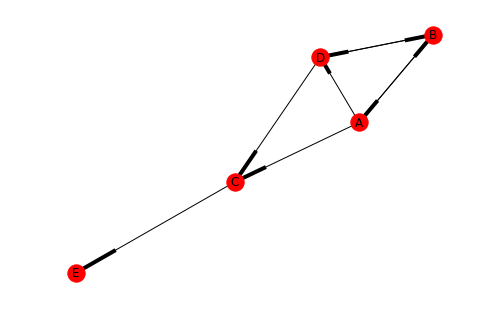

In [17]:
import re, sys
import networkx as nx
import matplotlib.pyplot as plt
from operator import add

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

#Funções auxiliares para cálculo dos scores de autoridade e hub
def calculaAut(x, y):
    for k in x: 
        yield (k, y)

def calculaHub(x, y):
    for k in x: 
        yield (k, y)   

#Cria um digrafo
DG = nx.DiGraph()
DG.add_edges_from([('A','B'),('A','C'),('A','D'),('B','A'),\
                   ('B','D'),('C','E'),('D','B'),('D','C')])

#Desenha grafo na tela
nx.draw(DG,with_labels=True)
plt.show()

In [18]:
#Cria RDD com os vértices do grafo
rddVertices = sc.parallelize(DG.out_edges)

#Lista dos links de saída
linksOut = rddVertices.distinct().groupByKey().cache()

#Lista dos links de entrada
linksIn = rddVertices.map(lambda (x,y): (y,x)).distinct().groupByKey().cache()

In [19]:
#Inicializa os scores de hub
rddHub = linksOut.map(lambda (x,y): (x, 1.0))

#Inicializa os scores de autoridade
rddAut = linksIn.map(lambda (x,y): (x, 1.0))

In [20]:
#Executa o algoritmo 15 vezes
for i in range(15):
    
    #Atualiza os scores de autoridade de todos os vértices presentes na lista de links de saída
    updateAut = linksOut.join(rddHub).flatMap(lambda (k, (x, y)): calculaAut(x, y))
    #Reduce dos scores de autoridade obtidos
    rddAut = updateAut.reduceByKey(add)
    #Normalizando os scores utilizando o score máximo
    maximo = rddAut.max(key = lambda x: x[1])[1]
    rddAut = rddAut.mapValues(lambda x: x/(maximo))
        
    #Atualiza os scores de hub de todos os vértices presentes na lista de links de entrada
    updateHub = linksIn.join(rddAut).flatMap(lambda (k, (x, y)): calculaHub(x, y))
    #Reduce dos scores de hub obtidos
    rddHub = updateHub.reduceByKey(add)
    #Normalizando os scores utilizando o score máximo
    maximo = rddHub.max(key = lambda x: x[1])[1]
    rddHub = rddHub.mapValues(lambda x: x/(maximo))

In [21]:
#Imprime os scores finais de autoridade e de hub para cada vértice
for (x, y) in rddAut.collect(): print "%s possui score de autoridade: %s" % (x, y)

for (x, y) in rddHub.collect(): print "%s possui score de hub: %s" % (x, y)

D possui score de autoridade: 0.486606389769
C possui score de autoridade: 0.614953988757
B possui score de autoridade: 0.614953988757
A possui score de autoridade: 0.128348981338
E possui score de autoridade: 8.4371932348e-11
A possui score de hub: 1.0
D possui score de hub: 0.716514816862
B possui score de hub: 0.358258213755
C possui score de hub: 4.91530592205e-11
